<a href="https://colab.research.google.com/github/jacobadodge/Spring2024_CVENG_8160/blob/main/HW01_Dodge_Jacob.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Instructions
***Assignment Details:***
You are provided with two datasets: localization and classification.
Localization: provides images and a csv file describing the location of objects in each image.
Classification: provides images collated in folders which describe the type of vehicle classes the images belong to. To complete this assignment:

***Download and extract both datasets:***
Use object oriented programming to write a custom data loader to read and transform both datasets. Note that localization will need labels to be transformed also.
The transforms to use should include: resizing of images, horizontal, vertical flip, tensor and normalization of data.
Include custom plotting functions to help visualize data.
***Rules:***
Feel free to use online resources. However, if you use any function or technique not discussed in class, demonstrate your understanding of the technique with at least 2 examples of how to use the function. You will lose points if this is not done
***Use google collab only***
While you may discuss this homework with your colleagues, your solution should not look too similar to others. You will be penalized for that.

##Preliminary Plan
1. Create a class to hold all of the functions
2. Create function to process each dataset (tuple in form of {'image': image_data, 'label': image_label})
3. Write functions to transform the images (resize, flip, tensor, normalization...?)
4. Write function to visualize images

In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
%cd '/content/drive/MyDrive/Masters/Semester 1/CVENG_8160_ADV_RES_METH_TRANS/module 03 (PyTorch fundamentals and linear regression)/Hw01'

/content/drive/MyDrive/Masters/Semester 1/CVENG_8160_ADV_RES_METH_TRANS/module 03 (PyTorch fundamentals and linear regression)/Hw01


In [60]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader # 'dataset' used to represent a dataset; 'dataloader' used to load batches of data for training and testing
from torchvision import transforms, utils
from pathlib import Path
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [74]:
# class to process images from folders
class Images():

  def __init__(self, class_root_dir, local_root_dir ):  # root_dir is root directory (where data is stored)

      # initialize dataset variables here
      self.class_root_dir = Path(class_root_dir)  # where the 'classificaiton' data resides
      self.local_root_dir = Path(local_root_dir)  # where the 'localization' data resides
      self.class_df = pd.DataFrame(columns = ['image_names','class_label']) # define column headers of data frame
      self.local_df = pd.DataFrame(columns = ['image_names', 'class_label'])  # define column headers of data frame

      # collect images from 'classification' data folder
      for fldr in self.class_root_dir.iterdir():  # self.root is root directory; iterdir() means loop through the folders and files in that directory
        class_img_names = []  #create empty list to append image names from root directory folders to
        if fldr.is_dir(): # if the current 'fldr' is a directory (a folder, not a file):
          class_img_names = class_img_names + list(fldr.glob('*.jpg'))  # .glob('.jpg') puts together the files with the extension '*.ppm'; the *.ppm files are then added to the 'img_names' list
        class_img_names = [i for i in class_img_names]  # idk the point of this (makes copy of existing list...?)
        class_df_cur = pd.DataFrame(class_img_names,columns = ['image_names'])  # create dataframe with one column 'image_names' w/ the data in that column being 'class_img_names'
        class_df_cur['class_label'] = fldr.name # .name strips the file path and just shows the folder name in a new column named 'class_label'
        self.class_df = pd.concat([self.class_df, class_df_cur],axis=0) # combine 'self.class_df' with 'class_df_cur' along the rows (axis 0)

      # collect images from 'local' data folder
      for fldr in self.local_root_dir.iterdir():
        local_img_names = []
        if fldr.is_dir():
          local_img_names = local_img_names + list(fldr.glob('*.jpg'))
        local_img_names = [i for i in local_img_names]
        local_df_cur = pd.DataFrame(local_img_names,columns = ['local_image_names'])
        local_df_cur['local_class_label'] = fldr.name
        self.local_df = pd.concat([self.local_df, local_df_cur])


      # shuffle the dataframe
      self.df = pd.concat([self.class_df, self.local_df], axis=0, ignore_index = True)
      self.df = self.df.sample(frac=1)
      self.df = pd.DataFrame(self.df)

      # group the images from the 'local' folder and 'classificaiton' folder together
      self.image_names = list(self.df['image_names'].values)
      self.class_label = list(self.df['class_label'].values)


  def __len__(self):  # dont call len but program will run it
      # returns the length of the dataset
      return len(self.image_names)

  def __getitem__(self, idx): # dont call getitem but program will run it

      # preprocess and transformations
      # indexes the dataset such that dataset[i] can retrieve the ith sample.
      image = self.image_names[idx]
      image_data = io.imread(image) # read the image
      # image_np = Image.fromarray(image_data)

      label = self.image_names[idx].name.replace('.jpg', ' ')

      sample = {'image': image_data, 'label': label}  # return a tuple of 'image' which is the image data and 'label' which is the image name

      return sample # whenever getitem is called for a certain index it will return an image and a label


# class to flip images
class Flip():

  def __init__(self, type_of_flip):
    assert isinstance(type_of_flip, int)
    self.type_of_flip = type_of_flip

  def __call__(self, sample): # automatically ran (don't need to call it)
        image, labels = sample['image'], sample['label']

        new_img = np.flip(image, self.type_of_flip)
        return {'image': new_img, 'label': labels}


# class to rescale images
class Rescale():

    def __init__(self, output_size):
        self.output_size = output_size

    def __call__(self, sample): # automatically ran (don't need to call it)
        image, labels = sample['image'], sample['label']

        h, w = image.shape[:2]

        if isinstance(self.output_size, int): # rescale images based on user input
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w) # make sure image size is integers (not floats)

        img = transform.resize(image, (new_h, new_w)) # imported module that transform/resize image

        return {'image': img, 'label': labels}  # return data of image and image label/name


In [75]:
obj = Images('/content/drive/MyDrive/Masters/Semester 1/CVENG_8160_ADV_RES_METH_TRANS/module 03 (PyTorch fundamentals and linear regression)/Hw01/classification/data', '/content/drive/MyDrive/Masters/Semester 1/CVENG_8160_ADV_RES_METH_TRANS/module 03 (PyTorch fundamentals and linear regression)/Hw01/localize')

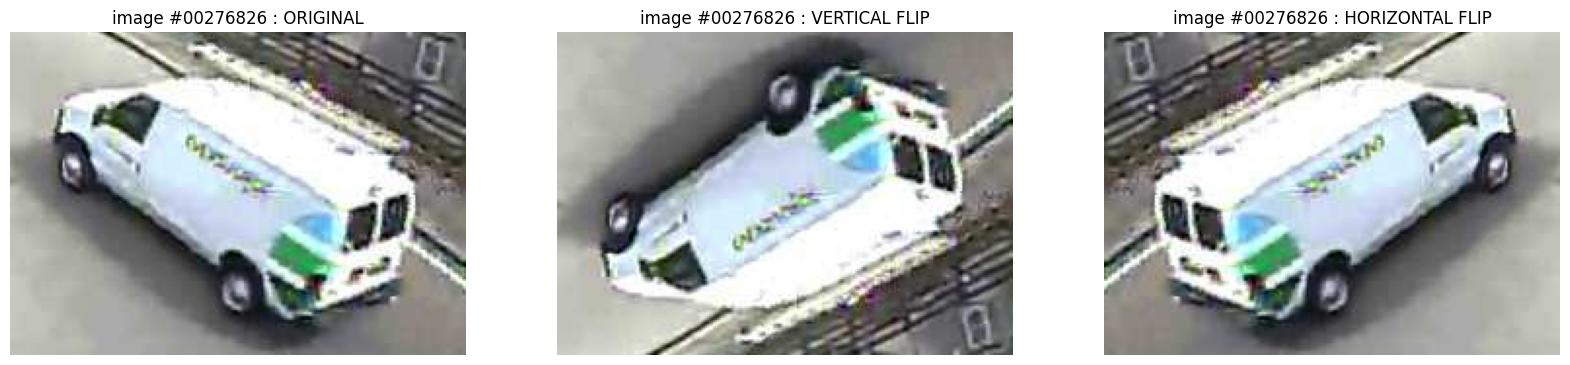

In [97]:
fig = plt.figure(figsize=(20,20))
for i in range(3):

  if i == 0:
    x = 'ORIGINAL'
  elif i == 1:
    x = 'VERTICAL FLIP'
  else:
    x = 'HORIZONTAL FLIP'

  image = obj[5]

  if i == 0:
    test_image = image['image']
    ax = plt.subplot(1, ncols, 1) # subplot: multiple plots in one plot: 1 row, 3 columns, which column your current iteration will reside
    ax.set_title('image #{}:'.format(sample['label']) + ' ' + x)  # set title of subplots (images)
    ax.axis('off')  # turn off axis labels becuase they're images
    plt.imshow(test_image)
    plt.show
  else:
    flip = Flip(i-1)
    image = flip(image)
    ax = plt.subplot(1, ncols, i + 1) # subplot: multiple plots in one plot: 1 row, 3 columns, which column your current iteration will reside
    ax.set_title('image #{}:'.format(sample['label']) + ' ' + x)  # set title of subplots (images)
    ax.axis('off')  # turn off axis labels becuase they're images
    plt.imshow(image['image'])
    plt.show

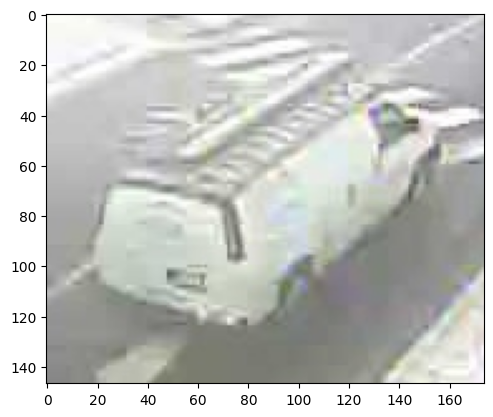

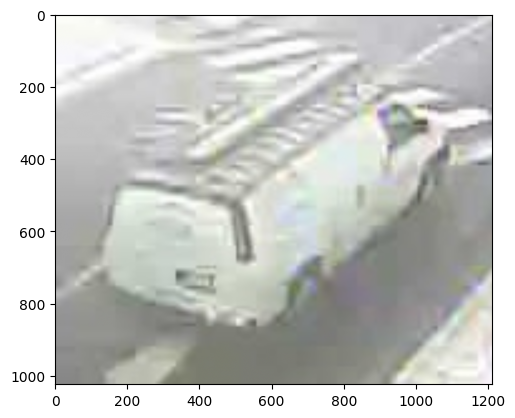

In [98]:
# original image
original_image = obj[8000]['image']
plt.imshow(original_image)
plt.show()

#scaled image
scale = Rescale(1024)
out_img = scale(obj[8000])  # pass the object 'obj' 8000th image into Rescale
plt.imshow(out_img['image'])  # show newly resized image

In [ ]:
# fig = plt.figure(figsize=(20,20)) # size of photos returned below
# ncols = 5 # number of columns for photos returned below
# for i, sample in enumerate(obj):  # enumerate through each value in 'obj' by index
#   #print(i, sample['image'].shape, sample['label'])  # printing: current itteration/index, image shape (size), image name
#   ax = plt.subplot(1, ncols, i + 1) # subplot: multiple plots in one plot: 1 row, 8 columns, which column your current iteration will reside
#   plt.tight_layout()  # make plots visible in window without scrolling sideways
#   ax.set_title('index {}: image #{}'.format(i, sample['label']))  # set title of subplots (images)
#   ax.axis('off')  # turn off axis labels becuase they're images
# # show_landmarks(**sample)
#   plt.imshow(sample['image']) # creates an image from given image data from 'sample['image']'

#   if i == ncols-1:
#       plt.show()
#       break # stop loop when reach ncols